In [1]:
import sys

from pathlib import Path
ROOT_PATH = Path.cwd().parent

# To access packages and files from root directory
sys.path.insert(1, str(ROOT_PATH))

In [2]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [3]:
numpyro.set_host_device_count(4)
print(jax.local_device_count())

4


In [4]:
def compute_ess_1dgp(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all spatial effects: " + str(round(r)))

In [5]:
FIG_PATH = Path.cwd() / 'figures/2DGP_figures'
FIG_PATH.mkdir(exist_ok=True, parents=True)

PUBLICATION_PATH = FIG_PATH / '2DGP_inference'
PUBLICATION_PATH.mkdir(exist_ok=True)

DATASET_PATH = ROOT_PATH / 'dataset.nosync'
DATASET_PATH.mkdir(exist_ok=True)

MODEL_PATH = Path.cwd() / 'models'

In [6]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [7]:
# create grid
n = 25
grid = jnp.arange(0, 1, 1/n)
u, v = jnp.meshgrid(grid, grid)

X = jnp.array([u.flatten(), v.flatten()]).transpose((1, 0))
IMAGE_SHAPE = (n, n)

adj_matrix, _, _, num_regions, _ = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

In [8]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP2DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  adj_matrix: np.ndarray = adj_matrix
  num_regions: int = num_regions

GP2D_ARGS = GP2DArgs()

In [9]:
BASE_GRAPH = dataset.create_grid_graph(GP2D_ARGS.adj_matrix)

# Load params

In [10]:
# VGAE+L2G
vgaeL2G_model_name = '2DGP_VGAE_L2G'
model_path = MODEL_PATH / vgaeL2G_model_name

print(f"Loading VGAE+L2G model from {model_path}")
vgaeL2G_params = model.restore_params(model_path)

print()
# VAE
vae_model_name = '2DGP_0.001lr_20000epochs_35h1Dim_30h2Dim_10latentDim_625numLocations_100batchSize'
model_path = ROOT_PATH / 'models' / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VGAE+L2G model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/models/2DGP_VGAE_L2G

Loading VAE model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/models/2DGP_0.001lr_20000epochs_35h1Dim_30h2Dim_10latentDim_625numLocations_100batchSize


# Models

In [11]:
from typing import Callable
import layer

def decoder_vgaeL2G(
        z: jnp.ndarray,
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (batch_size, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((batch_size*num_nodes, hidden_gnn_dim))
    # graph = BASE_GRAPH._replace(nodes=z)
    graph = graph._replace(nodes=z)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    x = graph.nodes.reshape(batch_size, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (batch_size, num_nodes*hidden_gnn_dim)

    x = hk.Linear(num_nodes, name='decoder_output')(x)

    return jnp.reshape(x, (batch_size*num_nodes, 1))

# Inference predictives

In [12]:
# VAE settings
vae_hidden1_dim = 30
vae_hidden2_dim = 35
vae_latent_dim = 10

vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=vae_hidden1_dim,
        hidden2_dim=vae_hidden2_dim,
        output_dim=GP2D_ARGS.num_regions
    )
))

def vae_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([vae_latent_dim]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [13]:
from functools import partial

# VGAE settings
vgae_latent_dim = 10
vgae_hidden_dim = 6

# VGAE+L2G
vgaeL2G_decoder_keys = [k for k in list(vgaeL2G_params.keys()) if k.startswith('vgae/decoder')]
vgaeL2G_decoder = {}
for full_key_name in vgaeL2G_decoder_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    vgaeL2G_decoder[key_name] = vgaeL2G_params[full_key_name]

vgaeL2G_decoder_net_fn = partial(decoder_vgaeL2G,
                         graph=BASE_GRAPH,
                         hidden_gnn_dim=vgae_hidden_dim,
                         output_dim=GP2D_ARGS.num_regions,
                         batch_size=1,
                         num_nodes=GP2D_ARGS.num_regions)
vgaeL2G_decoder_net = hk.without_apply_rng(hk.transform(vgaeL2G_decoder_net_fn))

def vgaeL2G_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([vgae_latent_dim]))
    vgae_out = jnp.squeeze(vgaeL2G_decoder_net.apply(vgaeL2G_decoder, z))
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

# Begin inference

In [14]:
# RNG_KEY = jax.random.PRNGKey(1)  # promising!
# RNG_KEY = jax.random.PRNGKey(11)
# RNG_KEY = jax.random.PRNGKey(4)
RNG_KEY = jax.random.PRNGKey(23)  # quite nice

RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
gp_draw = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
    gp_rng, x=X, gp_kernel=GP2D_ARGS.kernel, noise=True, kernel_length=0.27,
)
y_truth = gp_draw['f'].T
y_observed = gp_draw['y'].T

Text(0.5, 1.0, 'Ground truth with noise')

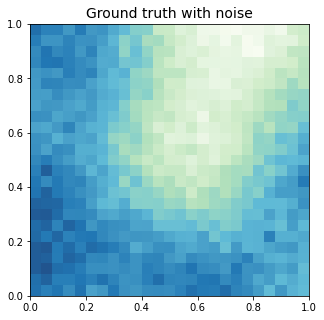

In [15]:
_, ax = plt.subplots(figsize=(5, 5))

# Mean plot
cmap_cols = "GnBu"
al = 0.9

im = ax.imshow(np.flip(y_observed.reshape(IMAGE_SHAPE), axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], origin='lower', alpha=al, aspect='auto',)
ax.set_title("Ground truth with noise", fontsize=14)

In [16]:
# Percentage of observed locations
pct_obs_locations = np.array([0.01, 0.02, 0.03])

num_obs_locations = np.round(pct_obs_locations * GP2D_ARGS.num_regions)
num_obs_locations = num_obs_locations.astype(int)

RNG_KEY = jax.random.PRNGKey(46)
RNG_KEY, choice_rng = jax.random.split(RNG_KEY)

obs_locations = [
    jax.random.choice(choice_rng, GP2D_ARGS.num_regions, shape=(num,), replace=False)
        for num in num_obs_locations
]
obs_locations

[DeviceArray([151, 112, 503, 137,   0, 441], dtype=int32),
 DeviceArray([151, 112, 503, 137,   0, 441, 592, 524, 293, 384, 178, 436], dtype=int32),
 DeviceArray([151, 112, 503, 137,   0, 441, 592, 524, 293, 384, 178, 436,
              375, 354, 344, 380, 224, 296, 121], dtype=int32)]

In [17]:
vae_mean_post_preds_list = []
vae_sd_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []
vae_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_observed[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vae_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vae_mcmc_objs.append(mcmc)

    predictions = Predictive(vae_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    sd_post_pred = jnp.std(predictions, axis=0)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_sd_post_preds_list.append(sd_post_pred)

Running chain for n_obs = 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 3.4709601402282715
Running chain for n_obs = 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.7390360832214355
Running chain for n_obs = 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.604787826538086


In [ ]:
vgaeL2G_mean_post_preds_list = []
vgaeL2G_sd_post_preds_list = []
obs_xs = []
obs_ys = []
vgaeL2G_predictions_list = []
vgaeL2G_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_observed[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgaeL2G_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vgaeL2G_mcmc_objs.append(mcmc)

    predictions = Predictive(vgaeL2G_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    sd_post_pred = jnp.std(predictions, axis=0)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vgaeL2G_predictions_list.append(predictions)
    vgaeL2G_mean_post_preds_list.append(mean_post_pred)
    vgaeL2G_sd_post_preds_list.append(sd_post_pred)

In [ ]:
print()
print('VGAEL2G')
for mcmc in vgaeL2G_mcmc_objs:
    compute_ess_1dgp(mcmc)

print()
print('VAE')
for mcmc in vae_mcmc_objs:
    compute_ess_1dgp(mcmc)



VGAEL2G
Average ESS for all spatial effects: 1792
Average ESS for all spatial effects: 2232
Average ESS for all spatial effects: 4150

VAE
Average ESS for all spatial effects: 291
Average ESS for all spatial effects: 2613
Average ESS for all spatial effects: 4254


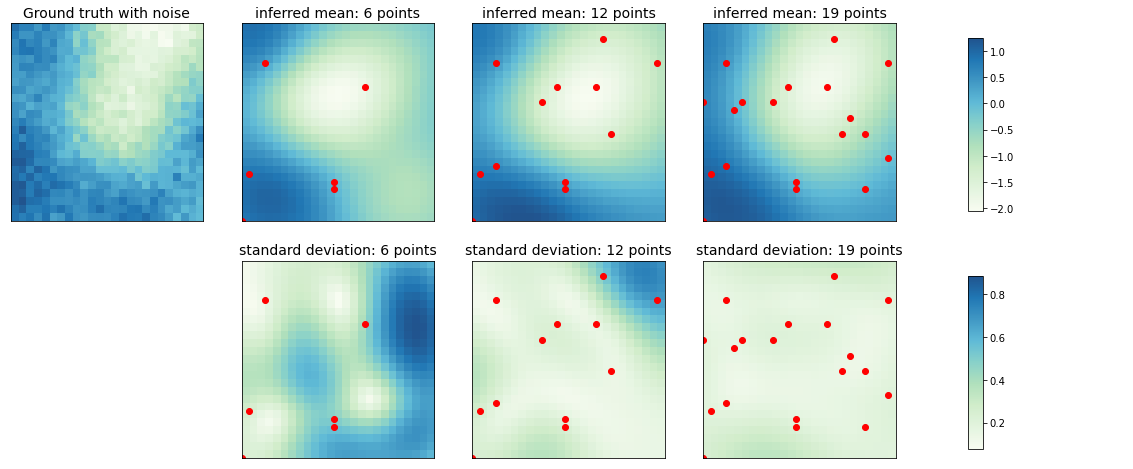

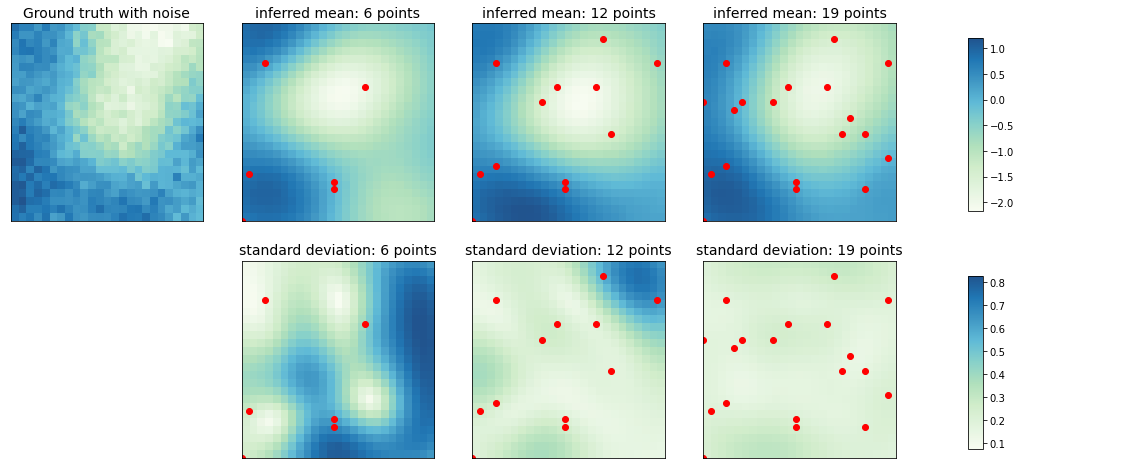

In [ ]:
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2+len(vgaeL2G_mean_post_preds_list), figsize=(20,8))
_min, _max = np.amin(vgaeL2G_mean_post_preds_list), np.amax(vgaeL2G_mean_post_preds_list)
al = 0.9
cmap_cols = "GnBu"

# Mean plot
im = axs[0,0].imshow(np.flip(y_observed.reshape(IMAGE_SHAPE), axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], origin='lower', alpha=al, aspect='auto',)
axs[0,0].set_title("Ground truth with noise", fontsize=14)
axs[0,0].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)

for i in range(len(vgaeL2G_mean_post_preds_list)):
    im = axs[0,i+1].imshow(np.flip(vgaeL2G_mean_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[0,i+1].set_title("inferred mean: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[0,i+1].axes.xaxis.set_visible(False)
    axs[0,i+1].axes.yaxis.set_visible(False)
    # axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[0,1+len(vgaeL2G_mean_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.555, 0.01, 0.30]) # left, bottom, width, height
fig.colorbar(im, ax=axs[0,1+len(vgaeL2G_mean_post_preds_list)], cax = cbaxes)


# Standard deviation plot
_min, _max = np.amin(vgaeL2G_sd_post_preds_list), np.amax(vgaeL2G_sd_post_preds_list)

axs[1,0].axis('off')

for i in range(len(vgaeL2G_sd_post_preds_list)):
    im = axs[1,i+1].imshow(np.flip(vgaeL2G_sd_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[1,i+1].set_title("standard deviation: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[1,i+1].axes.xaxis.set_visible(False)
    axs[1,i+1].axes.yaxis.set_visible(False)
    # axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[1,1+len(vgaeL2G_sd_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.142, 0.01, 0.30])
fig.colorbar(im, ax=axs[1,1+len(vgaeL2G_sd_post_preds_list)], cax = cbaxes)

# plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
save_to_dir.mkdir(exist_ok=True)
fig.savefig(save_to_dir / '2DGP_inference_PriorVGAE.jpg', dpi=300, bbox_inches='tight')
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# #plt.savefig('res/2d_n{}_infer_hyperpars.png'.format(n))
# plt.savefig('res/2d_n{}_infer_hyperpars.pdf'.format(n))



# VAE plot results
fig, axs = plt.subplots(nrows=2, ncols=2+len(vae_mean_post_preds_list), figsize=(20,8))
_min, _max = np.amin(vae_mean_post_preds_list), np.amax(vae_mean_post_preds_list)
al = 0.9
cmap_cols = "GnBu"

# Mean plot
im = axs[0,0].imshow(np.flip(y_observed.reshape(IMAGE_SHAPE), axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], origin='lower', alpha=al, aspect='auto',)
axs[0,0].set_title("Ground truth with noise", fontsize=14)
axs[0,0].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)

for i in range(len(vae_mean_post_preds_list)):
    im = axs[0,i+1].imshow(np.flip(vae_mean_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[0,i+1].set_title("inferred mean: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[0,i+1].axes.xaxis.set_visible(False)
    axs[0,i+1].axes.yaxis.set_visible(False)
    # axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[0,1+len(vae_mean_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.555, 0.01, 0.30]) # left, bottom, width, height
fig.colorbar(im, ax=axs[0,1+len(vae_mean_post_preds_list)], cax = cbaxes)


# Standard deviation plot
_min, _max = np.amin(vae_sd_post_preds_list), np.amax(vae_sd_post_preds_list)

axs[1,0].axis('off')

for i in range(len(vae_sd_post_preds_list)):
    im = axs[1,i+1].imshow(np.flip(vae_sd_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[1,i+1].set_title("standard deviation: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[1,i+1].axes.xaxis.set_visible(False)
    axs[1,i+1].axes.yaxis.set_visible(False)
    # axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[1,1+len(vae_sd_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.142, 0.01, 0.30])
fig.colorbar(im, ax=axs[1,1+len(vae_sd_post_preds_list)], cax = cbaxes)

# plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
save_to_dir.mkdir(exist_ok=True)
fig.savefig(save_to_dir / '2DGP_inference_PriorVAE.jpg', dpi=300, bbox_inches='tight')
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# #plt.savefig('res/2d_n{}_infer_hyperpars.png'.format(n))
# plt.savefig('res/2d_n{}_infer_hyperpars.pdf'.format(n))

In [ ]:
for idx, mean in enumerate(vgaeL2G_mean_post_preds_list):
    mse_vgae = np.mean((y_truth.flatten() -  mean)**2)
    print(f'mse_vgaeL2G ({len(obs_locations[idx])}) = {mse_vgae}')

print()
for idx, mean in enumerate(vae_mean_post_preds_list):
    mse_vgae = np.mean((y_truth.flatten() -  mean)**2)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgaeL2G (6) = 0.43736502528190613
mse_vgaeL2G (12) = 0.19999562203884125
mse_vgaeL2G (19) = 0.11958925426006317

mse_vae (6) = 0.4776284992694855
mse_vae (12) = 0.26815447211265564
mse_vae (19) = 0.1270366609096527


In [ ]:
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2+len(vgaeL2G_mean_post_preds_list), figsize=(20,8))
_min, _max = np.amin(vgaeL2G_mean_post_preds_list), np.amax(vgaeL2G_mean_post_preds_list)
al = 0.9
cmap_cols = "GnBu"

# Mean plot
im = axs[0,0].imshow(np.flip(y_observed.reshape(IMAGE_SHAPE), axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], origin='lower', alpha=al, aspect='auto',)
axs[0,0].set_title("Ground truth with noise", fontsize=14)
axs[0,0].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)

for i in range(len(vgaeL2G_mean_post_preds_list)):
    im = axs[0,i+1].imshow(np.flip(vgaeL2G_mean_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[0,i+1].set_title("inferred mean: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[0,i+1].axes.xaxis.set_visible(False)
    axs[0,i+1].axes.yaxis.set_visible(False)
    # axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[0,1+len(vgaeL2G_mean_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.555, 0.01, 0.30]) # left, bottom, width, height
fig.colorbar(im, ax=axs[0,1+len(vgaeL2G_mean_post_preds_list)], cax = cbaxes)


# Standard deviation plot
_min, _max = np.amin(vgaeL2G_sd_post_preds_list), np.amax(vgaeL2G_sd_post_preds_list)

axs[1,0].axis('off')

for i in range(len(vgaeL2G_sd_post_preds_list)):
    im = axs[1,i+1].imshow(np.flip(vgaeL2G_sd_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[1,i+1].set_title("standard deviation: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[1,i+1].axes.xaxis.set_visible(False)
    axs[1,i+1].axes.yaxis.set_visible(False)
    # axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[1,1+len(vgaeL2G_sd_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.142, 0.01, 0.30])
fig.colorbar(im, ax=axs[1,1+len(vgaeL2G_sd_post_preds_list)], cax = cbaxes)

# plt.tight_layout()
plt.show()

# save_to_dir = FIG_PATH / 'publication'
# save_to_dir.mkdir(exist_ok=True)
# fig.savefig(save_to_dir / '2DGP_inference_PriorVGAE.jpg', dpi=300, bbox_inches='tight')